In [32]:
# Библиотеки
import pandas as pd
from nltk.stem import SnowballStemmer 
from pymystem3 import Mystem
from io import BytesIO
import requests
import re
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
import warnings
import seaborn as sns
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
path_1 = 'D://Kseniia//AV//' 
data = pd.read_csv(path_1 + 'bq-results-20210713.csv')
transaction_date = pd.read_csv(path_1 + 'bq-results-20210714.csv')

In [3]:
# Основная информация о таблице
data.info()
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862484 entries, 0 to 1862483
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   transaction_id  int64  
 2   reciept_cost    float64
 3   deliveryZone    object 
 4   comments        object 
dtypes: float64(1), int64(2), object(2)
memory usage: 71.0+ MB


,user_id,transaction_id,reciept_cost,deliveryZone,comments
0,8903271874564,1779863839,5613.30,mo,NaN
1,8848493969412,1792865067,5787.00,mo,NaN
2,8906460135428,1786615161,8728.00,mo,нужен заказ пропуска
3,8912425451524,1794672582,4049.32,mo,NaN
4,8904413380612,1780003217,4477.00,mo,NaN
5,8947878887428,1794696215,8050.00,mo,NaN
6,8907171921924,1781576459,4171.90,mo,"1 подъезд, 16 этаж, квартира 61"
7,8900968775684,1791471630,6987.60,mo,NaN
8,8899019898884,1793805778,5819.40,mo,NaN
9,8801222590468,1791560735,8297.82,mo,NaN


In [4]:
transaction_date.info()
display(transaction_date.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862479 entries, 0 to 1862478
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   transaction_id  int64 
 2   time            object
dtypes: int64(2), object(1)
memory usage: 42.6+ MB


,user_id,transaction_id,time
0,8854594682884,1793833616,2021-01-12 15:52:04 UTC
1,8946728894468,1787816837,2021-01-12 17:30:36 UTC
2,8814050246660,1795220755,2021-01-12 14:54:00 UTC
3,8908227641348,1794719001,2021-01-12 15:18:48 UTC
4,8947979419652,1795220793,2021-01-12 15:22:46 UTC
5,8802623062020,1794841269,2021-01-12 15:39:17 UTC
6,8933557698564,1781167018,2021-01-12 16:15:23 UTC
7,8913048240132,1794858157,2021-01-12 17:04:24 UTC
8,8891644772356,1788445792,2021-01-12 17:09:36 UTC
9,8911410659332,1782315633,2021-01-12 18:11:52 UTC


In [5]:
# Изменим формат `time`
transaction_date['time'] = pd.to_datetime(transaction_date['time'])
transaction_date['date'] = transaction_date['time'].dt.date
transaction_date = transaction_date.drop('time', axis=1)
transaction_date.head(15)

,user_id,transaction_id,date
0,8854594682884,1793833616,2021-01-12
1,8946728894468,1787816837,2021-01-12
2,8814050246660,1795220755,2021-01-12
3,8908227641348,1794719001,2021-01-12
4,8947979419652,1795220793,2021-01-12
5,8802623062020,1794841269,2021-01-12
6,8933557698564,1781167018,2021-01-12
7,8913048240132,1794858157,2021-01-12
8,8891644772356,1788445792,2021-01-12
9,8911410659332,1782315633,2021-01-12


In [6]:
# Пропуски в deliveryZone
display(data[data['deliveryZone'].isna()].head(10)) 
print(len(data[data['deliveryZone'].isna()])) 

,user_id,transaction_id,reciept_cost,deliveryZone,comments
14772,8802033696772,1753822426,5430.32,NaN,NaN
45343,8897907032068,1877685200,16342.20,NaN,"Пожалуйста, только свежие продукты."
64760,8902719635460,1655777167,3097.90,NaN,NaN
65799,8916725661700,1664870400,4494.00,NaN,NaN
103818,8804088578052,1510470778,1450.00,NaN,NaN
103819,8804088578052,1510753007,1263.00,NaN,NaN
103820,8804088578052,1510948146,1130.00,NaN,NaN
103821,8804088578052,1511028116,1167.30,NaN,NaN
103822,8825128910852,1511972357,1057.50,NaN,NaN
103823,8802687647748,1511594323,2451.60,NaN,NaN


586856


In [7]:
# Проверка дубликатов
print(data.duplicated().sum())

0


In [8]:
# Обработка пропусков
data['deliveryZone'] = data['deliveryZone'].fillna(value='msk') 
data['comments'] = data['comments'].fillna(value='') 

In [9]:
data['comments'] = data['comments'].str.lower()


In [10]:
test_dic = ['тест', 'test', 'тестовый заказ', 'тестовый']
russian_stemmer = SnowballStemmer('russian')
def serch_test(query):
    for word in query.split(' '):
        stemmed_word = russian_stemmer.stem(word)
        for i in test_dic:
            if stemmed_word == i:
                return 'TEST'
    
    
data['comments'] = data['comments'].apply(serch_test)


In [11]:
data = data[data['comments'] != 'TEST']
display(data.sort_values(by = 'user_id').sample(15))

,user_id,transaction_id,reciept_cost,deliveryZone,comments
1101465,8845245906948,1580294274,3406.00,msk,None
1196161,8801542340612,1837632325,7344.70,omni_153,None
687147,8905835642884,1638090907,5205.00,msk,None
736924,8802694135812,1510744580,1711.00,msk,None
1290368,8826633486340,1874428954,10415.66,msk,None
181002,8802708684804,1400292355,3813.70,msk,None
952197,8802681552900,1400159930,1971.20,msk,None
1382818,8802042839044,1523758276,7582.95,mo,None
182750,8802618966020,1400249396,3672.30,msk,None
454965,8802254618628,1500722933,2901.60,msk,None


In [12]:
data['deliveryZone'].value_counts()

msk         1406077
mo           177730
spb_1         45288
mmk           24277
omni_78        8752
             ...   
spec_171          1
spec_114          1
spec_178          1
spec_102          1
spec_217          1
Name: deliveryZone, Length: 247, dtype: int64

In [13]:
splitted_Zone = data['deliveryZone']
splitted_Zone = splitted_Zone.str.split('_',  expand=True)

In [14]:
omni_spb = ['80', '81', '82', '83', '84', 
            '85', '198', '280', '127', '131', 
            '139', '170', '179', '203', '212']
def cat_delv(query):
    if query[0] == 'msk':
        return 'storage_msk'
    if query[0] == 'mo':
        return 'storage_msk'
    if query[0] == 'mmk':
        return 'storage_msk'
    if query[0] == 'spb':
        return 'storage_spb'
    if query[0] == 'omni':
        if query[1] in omni_spb:
            return 'omni_spb'
        else:
            return 'omni_msk'
    if query[0] == 'pickup':
        return 'pickup'
    if query[0] == 'spec':
        return 'spec'
    if query[1] == 'msk':
        return 'storage_msk'
    else: 
        return ''

splitted_Zone['cat_delv'] = splitted_Zone.apply(cat_delv, axis=1)
splitted_Zone.sample(10)

,0,1,2,cat_delv
783249,msk,None,None,storage_msk
1363518,omni,4,cst,omni_msk
1348342,msk,None,None,storage_msk
1698986,msk,None,None,storage_msk
908671,msk,None,None,storage_msk
1135164,msk,None,None,storage_msk
1616451,msk,None,None,storage_msk
583086,mo,None,None,storage_msk
1579570,msk,None,None,storage_msk
360685,msk,None,None,storage_msk


In [15]:
data = data.join(splitted_Zone['cat_delv'], how ='left')


In [16]:
data = data.merge(transaction_date, on = ['transaction_id','user_id'])


In [17]:
data = data[data['cat_delv'].isna() == False]
data.sample(15)

,user_id,transaction_id,reciept_cost,deliveryZone,comments,cat_delv,date
860811,8846884339716,1523967277,4990.10,msk,None,storage_msk,2018-03-18
977839,8803910713348,1526696130,6078.30,msk,None,storage_msk,2018-09-13
803815,8801418379268,1400206936,3073.14,msk,None,storage_msk,2015-10-20
938106,8802247311364,1400099556,12316.00,msk,None,storage_msk,2014-10-20
328327,8799930384388,1400071625,1428.38,msk,None,storage_msk,2014-06-04
972551,8850228805636,1526722063,2893.20,msk,None,storage_msk,2018-09-29
845932,8822966878212,1526106393,2250.00,msk,None,storage_msk,2018-07-30
705674,8938019717124,1774439261,2280.00,omni_69,None,omni_msk,2020-12-04
1438732,8800982761476,1400218379,1087.00,msk,None,storage_msk,2015-11-19
1326123,8845868072964,1778057372,6643.30,mo,None,storage_msk,2020-12-15


In [18]:
# Посмотрим на поведение клиентов за год
orders = data[['user_id', 'date', 'reciept_cost', 'cat_delv']]
orders['date'] = orders['date'].astype('datetime64[h]')
orders = orders.query('date > "2020-07-13"')
print(orders['date'].min())
print(orders['date'].max())

2020-07-14 00:00:00
2021-07-13 00:00:00


In [19]:
# Дата совершения первого события пользователя
min_month_order = orders.groupby(['user_id'])['date'].min()
min_month_order.name = 'min_month_order'
orders = orders.join(min_month_order,on='user_id') 
orders['min_month_order'] = orders['min_month_order'].astype('datetime64[M]')
orders['order_month'] = orders['date'].astype('datetime64[M]')

In [20]:
# Сгруппируем датафрейм по пользователям и подсчитаем количество уникальных сервисов:
count_cat_delv_by_users = orders.groupby(['user_id']).agg({'cat_delv':'nunique'}).reset_index()
count_cat_delv_by_users = count_cat_delv_by_users.rename(columns={'cat_delv':'number_cat_delv'})
count_cat_delv_by_users['number_cat_delv'].value_counts()

1    68854
2    15758
3      661
4       84
5        4
Name: number_cat_delv, dtype: int64

In [21]:
# Разделим пользователей по целевому поведению

#  1 вид сервиса
count_cat_delv_by_users['is_target_behavior'] = (count_cat_delv_by_users['number_cat_delv'] < 2)
user_ids_with_target_behavior_1 = count_cat_delv_by_users[count_cat_delv_by_users['is_target_behavior']]['user_id'].unique()


#  2 вида сервиса
count_cat_delv_by_users['is_target_behavior'] = (count_cat_delv_by_users['number_cat_delv'] == 2)
user_ids_with_target_behavior_2 = count_cat_delv_by_users[count_cat_delv_by_users['is_target_behavior']]['user_id'].unique()
 

#  3 и более вида сервиса
count_cat_delv_by_users['is_target_behavior'] = (count_cat_delv_by_users['number_cat_delv'] > 2)
user_ids_with_target_behavior_3 = count_cat_delv_by_users[count_cat_delv_by_users['is_target_behavior']]['user_id'].unique()

 

В основном датафрейме разделим пользователей на 3 группы:
- Клиенты, которые пользовались 1 видом сервиса;
- Клиенты, которые пользовались 2 видами сервиса;
- Клиенты, которые пользовались 3 и более видами сервиса

In [22]:
orders.loc[orders['user_id'].isin(user_ids_with_target_behavior_1),'is_in_behavioral_cohort'] = '1'
orders.loc[orders['user_id'].isin(user_ids_with_target_behavior_2), 'is_in_behavioral_cohort'] = '2'
orders.loc[orders['user_id'].isin(user_ids_with_target_behavior_3), 'is_in_behavioral_cohort'] = 'more'
print(orders.groupby('is_in_behavioral_cohort')['user_id'].nunique())

is_in_behavioral_cohort
1       68854
2       15758
more      749
Name: user_id, dtype: int64


In [23]:
# Lifetime клиента в рамках когорты
orders['cohort_lifetime'] = orders['order_month'] - orders['min_month_order']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].astype('int') 

In [24]:
# Retention Rate для каждой поведенческой когорты

def printRetentionRate(df):
    cohorts = df.groupby(['min_month_order','cohort_lifetime'],as_index=False).agg({'user_id':'nunique'}).sort_values(['min_month_order','cohort_lifetime'])

    inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['min_month_order','user_id']]
    inital_users_count = inital_users_count.rename(columns={'user_id':'cohort_users'})
    cohorts = cohorts.merge(inital_users_count,on='min_month_order')
    cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
    print (cohorts.groupby(['cohort_lifetime'])['retention'].mean())
    cohorts.groupby(['cohort_lifetime'])['retention'].mean().plot.bar() 

cohort_lifetime
0     1.000000
1     0.194211
2     0.143055
3     0.130956
4     0.115963
5     0.122980
6     0.123285
7     0.131100
8     0.064631
9     0.160066
10    0.055691
11    0.282975
Name: retention, dtype: float64


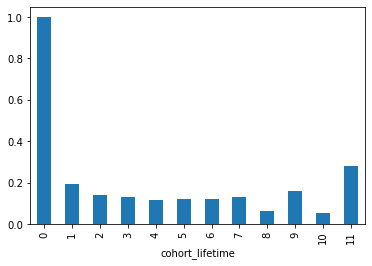

In [25]:
#  1 вид сервиса
printRetentionRate(orders[orders['is_in_behavioral_cohort'] == '1']) 

cohort_lifetime
0     1.000000
1     0.584086
2     0.500905
3     0.451594
4     0.408708
5     0.423153
6     0.418855
7     0.417534
8     0.312088
9     0.444664
10    0.270622
11    0.629145
Name: retention, dtype: float64


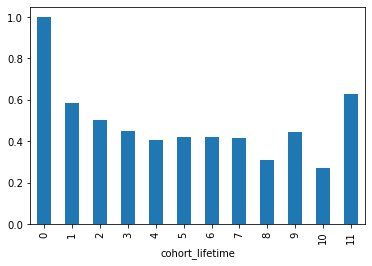

In [26]:
#  2 вид сервиса
printRetentionRate(orders[orders['is_in_behavioral_cohort'] == '2']) 

cohort_lifetime
0     1.000000
1     0.732074
2     0.637855
3     0.619426
4     0.566742
5     0.565226
6     0.507731
7     0.540945
8     0.456701
9     0.568245
10    0.364486
11    0.702290
Name: retention, dtype: float64


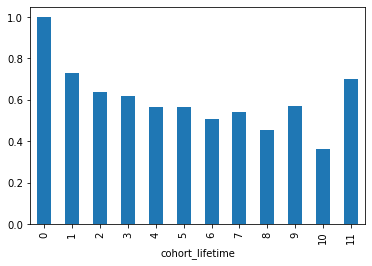

In [27]:
#  3 вид сервиса
printRetentionRate(orders[orders['is_in_behavioral_cohort'] == 'more']) 

### Вывод

При сравнении графиков очевидно, что чем больше видов сервиса клиенты используют, тем выше показатель Retention Rate

In [28]:
# ARPU 
user_ARPU = orders.groupby(['user_id']).agg({'reciept_cost':'sum'}).reset_index()
user_ARPU = user_ARPU.rename(columns={'reciept_cost':'ARPU'})
user_ARPU.head()

,user_id,ARPU
0,8799688032260,264322.96
1,8799688130564,10001.52
2,8799688294404,226077.82
3,8799688359940,63805.60
4,8799688458244,103368.35


In [29]:
user_ARPU.loc[user_ARPU['user_id'].isin(user_ids_with_target_behavior_1),'is_in_behavioral_cohort'] = '1'
user_ARPU.loc[user_ARPU['user_id'].isin(user_ids_with_target_behavior_2), 'is_in_behavioral_cohort'] = '2'
user_ARPU.loc[user_ARPU['user_id'].isin(user_ids_with_target_behavior_3), 'is_in_behavioral_cohort'] = 'more'

In [45]:
# ARPU для каждой поведенческой когорты
user_ARPU = user_ARPU[user_ARPU['ARPU'] > 0]

In [59]:
print('Max',user_ARPU.query('is_in_behavioral_cohort =="1"')['ARPU'].max())
print('Median',user_ARPU.query('is_in_behavioral_cohort =="1"')['ARPU'].median())
print('Mean',user_ARPU.query('is_in_behavioral_cohort =="1"')['ARPU'].mean())
print()
print(user_ARPU.query('is_in_behavioral_cohort =="1"')['ARPU'].describe())


Max 3030460.0
Median 5169.0
Mean 19787.928386403488

count    6.884000e+04
mean     1.978793e+04
std      7.161065e+04
min      1.836000e+01
25%      3.026883e+03
50%      5.169000e+03
75%      1.162500e+04
max      3.030460e+06
Name: ARPU, dtype: float64


In [60]:
print('Max',user_ARPU.query('is_in_behavioral_cohort =="2"')['ARPU'].max())
print('Median',user_ARPU.query('is_in_behavioral_cohort =="2"')['ARPU'].median())
print('Mean',user_ARPU.query('is_in_behavioral_cohort =="2"')['ARPU'].mean())
print()
print(user_ARPU.query('is_in_behavioral_cohort =="2"')['ARPU'].describe())

Max 5668656.200000001
Median 41713.399999999994
Mean 107033.46545858476

count    1.575500e+04
mean     1.070335e+05
std      1.792797e+05
min      1.675500e+03
25%      1.720544e+04
50%      4.171340e+04
75%      1.162990e+05
max      5.668656e+06
Name: ARPU, dtype: float64


In [61]:
print('Max',user_ARPU.query('is_in_behavioral_cohort =="more"')['ARPU'].max())
print('Median',user_ARPU.query('is_in_behavioral_cohort =="more"')['ARPU'].median())
print('Mean',user_ARPU.query('is_in_behavioral_cohort =="more"')['ARPU'].mean())
print()
print(user_ARPU.query('is_in_behavioral_cohort =="more"')['ARPU'].describe())

Max 2616703.3000000003
Median 95436.95
Mean 188688.20732977317

count    7.490000e+02
mean     1.886882e+05
std      2.534776e+05
min      6.458000e+03
25%      3.956430e+04
50%      9.543695e+04
75%      2.463689e+05
max      2.616703e+06
Name: ARPU, dtype: float64


In [66]:
# Избавимся от выбросов
user_ARPU_1 = user_ARPU.query('is_in_behavioral_cohort =="1"')
user_ARPU_2 = user_ARPU.query('is_in_behavioral_cohort =="2"')
user_ARPU_more = user_ARPU.query('is_in_behavioral_cohort =="more"')
user_ARPU_clear = pd.concat([user_ARPU_1[user_ARPU_1['ARPU'] < 11700][['user_id', 'ARPU','is_in_behavioral_cohort']],
        user_ARPU_2[user_ARPU_2['ARPU'] < 117000][['user_id','ARPU', 'is_in_behavioral_cohort']],
        user_ARPU_more[user_ARPU_more['ARPU'] < 247000][['user_id','ARPU', 'is_in_behavioral_cohort']]], axis=0)
user_ARPU_clear

,user_id,ARPU,is_in_behavioral_cohort
1,8799688130564,10001.52,1
7,8799691800580,6125.80,1
10,8799693832196,4053.00,1
12,8799693963268,4304.00,1
13,8799694159876,6645.00,1
...,...,...,...
75142,8957313155076,77965.20,more
79624,8963422027780,19695.72,more
80181,8964231004164,64833.70,more
81336,8965437358084,77575.30,more


In [73]:
fig = px.line(user_ARPU_clear, y='ARPU', color = 'is_in_behavioral_cohort' , title='Распределение ARPU в зависимости от количества используемых сервисов')
fig.show() 


<img src=http://joxi.ru/4AkWJKOSkQzzDA.jpg><br>

### Вывод

Судя по распределению ARPU выше в группах, использующих 2 и более сервиса. Стоит отметить, что у клиентов, использующих 2 сервиса показатели более стабильные, чем у клиентов, использующих 3 и более сервиса.